# Portfolio optimisation on Dow Jones Index

Make sure we are running the correct Python version.

In [2]:
import sys
sys.version

'3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]'

Install necessary packages.

In [3]:
!pip install plotly==4.4.1
!pip install -U kaleido #still having issues with plotly in SageMaker
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install wrds
!pip install swig

!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install PyPortfolioOpt
!pip install matplotlib

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-ixjza_pe
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-ixjza_pe
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 7c71056dd6d72e205096696319a2d8bd4a2bfe23
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-otuaggna/elegantrl_e77a3d38da3f453a8f40544693389242
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-ins

Import necessary libraries.

In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS

In [5]:
# Check what version of FinRL we are using.
!pip show finrl

Name: finrl
Version: 0.3.6
Summary: FinRL: Financial Reinforcement Learning Framework. Version 0.3.5 notes: stable version, code refactoring, more tutorials, clear documentation
Home-page: 
Author: Hongyang Yang, Xiaoyang Liu
Author-email: 
License: MIT
Location: /home/studio-lab-user/.conda/envs/py310fin/lib/python3.10/site-packages
Requires: alpaca-trade-api, ccxt, elegantrl, exchange-calendars, jqdatasdk, pyfolio, pyportfolioopt, ray, scikit-learn, stable-baselines3, stockstats, wrds, yfinance
Required-by: 


In [6]:
# create local directories to store trained models and results

import os
from finrl import config
from finrl import config_tickers

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

## Download the data

We shall get our stock data from Yahoo Finance website.

FinRL uses a class YahooDownloader to fetch data from Yahoo Finance API.

In [7]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2023-10-20',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Prepare the data

We shall augment the stock date with: 

* technical indicators such as MACD and RSI.
* turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [8]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
116460,2023-10-19,536.820007,538.340027,529.250000,531.630005,2351200,UNH,3
116461,2023-10-19,237.470001,237.919998,233.410004,233.809998,5927400,V,3
116462,2023-10-19,31.420000,31.969999,31.400000,31.580000,28806600,VZ,3
116463,2023-10-19,21.190001,21.629999,20.920000,20.959999,10863500,WBA,3
116464,2023-10-19,161.429993,161.820007,160.220001,160.770004,3915300,WMT,3


In [10]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [11]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
95471,2023-10-19,167.949997,169.500000,163.389999,163.940002,1778900,TRV,3,0.383356,170.494195,159.196804,48.133700,18.907984,8.367218,164.872667,164.553129
99449,2023-10-19,536.820007,538.340027,529.250000,531.630005,2351200,UNH,3,10.874309,544.413963,495.360045,61.045022,101.820656,36.537744,508.264003,501.554140
103427,2023-10-19,31.420000,31.969999,31.400000,31.580000,28806600,VZ,3,-0.364956,32.555492,30.405616,45.623921,-47.867823,21.290687,31.983648,32.403844
107405,2023-10-19,21.190001,21.629999,20.920000,20.959999,10863500,WBA,3,-0.332459,23.830909,20.322091,37.035356,-112.468884,22.223325,22.032667,24.547243
111383,2023-10-19,161.429993,161.820007,160.220001,160.770004,3915300,WMT,3,-0.182913,164.248891,156.069110,52.169177,-14.107137,1.939487,161.429667,160.405886


We shall add **covariance matrix** as states. This shall be done with 1 year lookback.

In [12]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

## Training environment

Training data split: 2009-01-01 to 2022-01-30. Date after 2022-01-30 will be used for testing the model.

In [13]:
train = data_split(df, '2009-01-01','2022-01-30')

The trading environment used here is based on OpenAI Gym framework, simulates live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed portfolio weights that the agent interacts with the environment.

In [14]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            weights = self.softmax_normalization(actions) 
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            log_portfolio_return = np.log(sum((self.data.close.values / last_day_memory.close.values)*weights))
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [15]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)
print(f"Feature Dimension: {feature_dimension}")

Stock Dimension: 28, State Space: 28
Feature Dimension: 4


In [16]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [17]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/home/studio-lab-user/.conda/envs/py310fin/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


### Implementation of Deep Reinforcement Learning

In the literature, PPO and A2C are two DRL algorithms that have demonstrated supreme performance in dealing with stock trading date. We shall therefore focus on these two DRL models.

### A2C model

In [18]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cpu device


In [19]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',
                                total_timesteps=40000)

-------------------------------------
| time/                 |           |
|    fps                | 341       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0004    |
|    n_updates          | 99        |
|    policy_loss        | 4.16e+08  |
|    reward             | 2066920.9 |
|    std                | 0.997     |
|    value_loss         | 1.47e+14  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 356       |
|    iterations         | 200       |
|    time_elapsed       | 5         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0004    |
|    n_updat

### PPO model

In [20]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.001, 'batch_size': 128}
Using cpu device


In [21]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=40000)

----------------------------------
| time/              |           |
|    fps             | 439       |
|    iterations      | 1         |
|    time_elapsed    | 4         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 4335617.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:8520795.128172552
Sharpe:  1.0141401810143174
---------------------------------------
| time/                   |           |
|    fps                  | 382       |
|    iterations           | 2         |
|    time_elapsed         | 10        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -39.7     |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 8.57e+14  |
|    n_updates            | 10       

## Back-Testing

Assume that we have one million dollars as initial capital at 2022-01-30. We use the PPO, A2C, Linear Regression, Decision Tree models to trade Dow jones 30 constituent stocks.


In [22]:
train.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
3291,2022-01-28,166.089996,166.839996,163.419998,160.539276,1233500,TRV,4,2.511829,164.196305,150.027422,56.966609,82.043046,33.263088,154.978173,151.818613,"[[0.0002425488698760198, 5.4192334993193164e-0...",tic AAPL AMGN AXP ...
3291,2022-01-28,461.399994,466.279999,455.079987,454.888184,3364400,UNH,4,-4.312382,486.789730,431.651790,50.851137,-69.778924,10.754147,467.285687,456.324923,"[[0.0002425488698760198, 5.4192334993193164e-0...",tic AAPL AMGN AXP ...
3291,2022-01-28,51.439999,52.930000,51.189999,47.285744,29490800,VZ,4,0.081075,48.930596,45.721113,52.740136,-60.271412,7.403198,47.073319,46.236529,"[[0.0002425488698760198, 5.4192334993193164e-0...",tic AAPL AMGN AXP ...
3291,2022-01-28,49.939999,50.490002,49.320000,46.057030,5430400,WBA,4,0.008909,50.814093,45.549696,49.572327,-82.723858,26.110880,47.461131,45.610090,"[[0.0002425488698760198, 5.4192334993193164e-0...",tic AAPL AMGN AXP ...
3291,2022-01-28,136.000000,137.570007,133.949997,133.852966,8377300,WMT,4,-1.378665,144.495309,132.007610,44.038922,-153.402546,33.938611,137.902030,138.747058,"[[0.0002425488698760198, 5.4192334993193164e-0...",tic AAPL AMGN AXP ...


In [23]:
trade = data_split(df,'2022-01-30', '2023-10-20')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [24]:
import torch
%matplotlib inline
import plotly.express as px


In [25]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [26]:
import pyfolio
%matplotlib inline
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

baseline_df = get_baseline(
        ticker="^DJI", 
        start = '2022-01-30',
        end =  '2023-10-20')

baseline_df_stats = backtest_stats(baseline_df, value_col_name = 'close')
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

dji_cumpod =(baseline_returns+1).cumprod()-1

/home/studio-lab-user/.conda/envs/py310fin/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning:

Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.



[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (433, 8)
Annual return         -0.028753
Cumulative returns    -0.048893
Annual volatility      0.167972
Sharpe ratio          -0.090208
Calmar ratio          -0.146030
Stability              0.083889
Max drawdown          -0.196895
Omega ratio            0.984904
Sortino ratio         -0.126445
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.035724
Daily value at risk   -0.021223
dtype: float64


In [27]:
from pyfolio import timeseries

df_daily_return_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)
df_daily_return_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)
time_ind = pd.Series(df_daily_return_a2c.date)
a2c_cumpod =(df_daily_return_a2c.daily_return+1).cumprod()-1
ppo_cumpod =(df_daily_return_ppo.daily_return+1).cumprod()-1
DRL_strat_a2c = convert_daily_return_to_pyfolio_ts(df_daily_return_a2c)
DRL_strat_ppo = convert_daily_return_to_pyfolio_ts(df_daily_return_ppo)

perf_func = timeseries.perf_stats 
perf_stats_all_a2c = perf_func( returns=DRL_strat_a2c, 
                              factor_returns=DRL_strat_a2c, 
                                positions=None, transactions=None, turnover_denom="AGB")
perf_stats_all_ppo = perf_func( returns=DRL_strat_ppo, 
                              factor_returns=DRL_strat_ppo, 
                                positions=None, transactions=None, turnover_denom="AGB")

/home/studio-lab-user/.conda/envs/py310fin/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:959827.2703604463
Sharpe:  -0.05288653289911602
hit end!


/home/studio-lab-user/.conda/envs/py310fin/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:966597.1807788754
Sharpe:  -0.032745569904491685
hit end!


In [28]:
def extract_weights(drl_actions_list):
  a2c_weight_df = {'date':[], 'weights':[]}
  for i in range(len(drl_actions_list)):
    date = drl_actions_list.index[i]
    tic_list = list(drl_actions_list.columns)
    weights_list = drl_actions_list.reset_index()[list(drl_actions_list.columns)].iloc[i].values
    weight_dict = {'tic':[], 'weight':[]}
    for j in range(len(tic_list)):
      weight_dict['tic'] += [tic_list[j]]
      weight_dict['weight'] += [weights_list[j]]

    a2c_weight_df['date'] += [date]
    a2c_weight_df['weights'] += [pd.DataFrame(weight_dict)]

  a2c_weights = pd.DataFrame(a2c_weight_df)
  return a2c_weights

a2c_weights = extract_weights(df_actions_a2c)
ppo_weights = extract_weights(df_actions_ppo)

## Machine learning models

We trained the machine learning models with technical indicators.

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor 

def prepare_data(trainData):
  train_date = sorted(set(trainData.date.values))
  X = []
  for i in range(0, len(train_date) - 1):
    d = train_date[i]
    d_next = train_date[i+1]
    y = train.loc[train['date'] == d_next].return_list.iloc[0].loc[d_next].reset_index()
    y.columns = ['tic', 'return']
    x = train.loc[train['date'] == d][['tic','macd','rsi_30','cci_30','dx_30']]
    train_piece = pd.merge(x, y, on = 'tic')
    train_piece['date'] = [d] * len(train_piece)
    X += [train_piece]
  trainDataML = pd.concat(X)
  X = trainDataML[tech_indicator_list].values
  Y = trainDataML[['return']].values

  return X, Y

train_X, train_Y = prepare_data(train)
#rf_model = RandomForestRegressor(max_depth = 35,  min_samples_split = 10, random_state = 0).fit(train_X, train_Y.reshape(-1))
#dt_model = DecisionTreeRegressor(random_state = 0, max_depth=35, min_samples_split = 10 ).fit(train_X, train_Y.reshape(-1))
dt_model = DecisionTreeRegressor().fit(train_X, train_Y.reshape(-1))

#svm_model =  SVR(epsilon=0.14).fit(train_X, train_Y.reshape(-1))
lr_model = LinearRegression().fit(train_X, train_Y)

In [30]:
def output_predict(model, reference_model = False):
  meta_coefficient = {"date":[], "weights":[]}

  portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
  initial_capital = 1000000
  portfolio.loc[0,unique_trade_date[0]] = initial_capital

  for i in range(len(unique_trade_date) - 1):
      
      current_date = unique_trade_date[i]
      next_date = unique_trade_date[i+1]
      df_current = df[df.date==current_date].reset_index(drop=True)
      tics = df_current['tic'].values
      features = df_current[tech_indicator_list].values
      df_next = df[df.date==next_date].reset_index(drop=True)
      if not reference_model:
        predicted_y = model.predict(features)      
        mu = predicted_y
        Sigma = risk_models.sample_cov(df_current.return_list[0], returns_data=True)
      else:
        mu = df_next.return_list[0].loc[next_date].values
        Sigma = risk_models.sample_cov(df_next.return_list[0], returns_data=True)
      predicted_y_df = pd.DataFrame({"tic":tics.reshape(-1,), "predicted_y":mu.reshape(-1,)})
      min_weight, max_weight = 0, 1
      ef = EfficientFrontier(mu, Sigma)
      weights = ef.nonconvex_objective(
          objective_functions.sharpe_ratio,
          objective_args=(ef.expected_returns, ef.cov_matrix),
          weights_sum_to_one=True,
          constraints=[
              {"type": "ineq", "fun": lambda w: w - min_weight},  # greater than min_weight
              {"type": "ineq", "fun": lambda w: max_weight - w},  # less than max_weight
          ],
      )
      
      weight_df = {"tic":[], "weight":[]}
      meta_coefficient["date"] += [current_date]
      # it = 0
      for item in weights:
        weight_df['tic'] += [item]
        weight_df['weight'] += [weights[item]]
      
      weight_df = pd.DataFrame(weight_df).merge(predicted_y_df, on = ['tic'])
      meta_coefficient["weights"] += [weight_df]
      cap = portfolio.iloc[0, i]
      #current cash invested for each stock
      current_cash = [element * cap for element in list(weights.values())]
      # current held shares
      current_shares = list(np.array(current_cash) / np.array(df_current.close))
      # next time period price
      next_price = np.array(df_next.close)
      portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
      
  portfolio=portfolio.T
  portfolio.columns = ['account_value']
  portfolio = portfolio.reset_index()
  portfolio.columns = ['date', 'account_value']
  stats = backtest_stats(portfolio, value_col_name = 'account_value')
  portfolio_cumprod =(portfolio.account_value.pct_change()+1).cumprod()-1

  return portfolio, stats, portfolio_cumprod, pd.DataFrame(meta_coefficient)

lr_portfolio, lr_stats, lr_cumprod, lr_weights = output_predict(lr_model)
dt_portfolio, dt_stats, dt_cumprod, dt_weights = output_predict(dt_model)
#svm_portfolio, svm_stats, svm_cumprod, svm_weights = output_predict(svm_model)
#rf_portfolio, rf_stats, rf_cumprod, rf_weights = output_predict(rf_model)
reference_portfolio, reference_stats, reference_cumprod, reference_weights = output_predict(None, True)

Annual return          0.135195
Cumulative returns     0.243442
Annual volatility      0.425659
Sharpe ratio           0.511023
Calmar ratio           0.287167
Stability              0.504625
Max drawdown          -0.470790
Omega ratio            1.092940
Sortino ratio          0.740033
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989756
Daily value at risk   -0.052765
dtype: float64
Annual return          0.010735
Cumulative returns     0.018516
Annual volatility      0.253504
Sharpe ratio           0.168370
Calmar ratio           0.036766
Stability              0.276296
Max drawdown          -0.291975
Omega ratio            1.029081
Sortino ratio          0.244231
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.048567
Daily value at risk   -0.031769
dtype: float64
Annual return            1078.561446
Cumulative returns     162887.087418
Annual volatility           0.351771
Sharpe ratio               

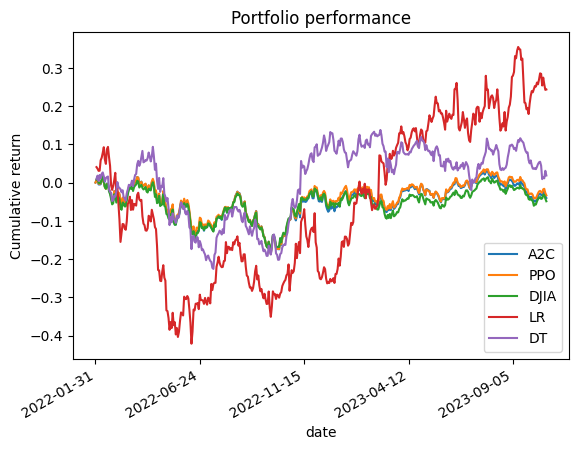

In [31]:
pred_dic = {'time': np.array(time_ind),'A2C': np.array(a2c_cumpod),'PPO': np.array(ppo_cumpod), 'DJIA':np.array(dji_cumpod),'LR': np.array(lr_cumprod), 'DT': np.array(dt_cumprod)}
pred_df = pd.DataFrame(data=pred_dic)
pred_df = pred_df.set_index(time_ind)
ax = pred_df.plot(title="Portfolio performance")
ax.set_ylabel("Cumulative return")
plt.gcf().autofmt_xdate()
